# Simple Regression Example

Julie Butler Hartley

Version 1.0.0

Date Created: October 28, 2020

Last Modified: October 28, 2020

The following notebook demonstrates the abilities of linear regression, ridge regression, and kernel ridge regression to extrapolate data using sequential (time-series formatting).


## Imports

In [1]:

# SYSTEM LEVEL IMPORTS
# Import files from other directories
import sys

# THIRD-PARTY IMPORTS
# For array handling
import numpy as np
# Linear Ridge Method
from sklearn.linear_model import LinearRegression
# Ridge Methods
from sklearn.linear_model.ridge import Ridge
# Kernel Ridge Methods
from sklearn.kernel_ridge import KernelRidge
# Prevents extraneous printing of messages during a grid search
import warnings
# For graphing 
import matplotlib.pyplot as plt

# LOCAL IMPORTS
# Changing the import directory
sys.path.append('../DataSets/')
# Data sets (mostly physics related)
from DataSets import *
from ElectronGas import *
from NuclearBindingEnergy import *

/Library/Python/3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.ridge module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


## Formatting the Data

The way the regression algorithms are trained in this program differs from how machine learning algorithms are usually trained, but is similar to a training method typically only done on recurrent neural networks.  Typically a machine learning algorithm is trained by learning the relationship between the x data and the y data.  In this program, the recurrent neural network will be trained to recognize the relationship in a sequence of y values.  This is type of data formatting is typically used time series forcasting, but it can also be used in any extrapolation (time series forecasting is just a specific type of extrapolation along the time axis).  This method of data formatting does not use the x data and assumes that the y data are evenly spaced.

For a standard machine learning algorithm, the training data has the form of (x,y) so the machine learning algorithm learns to assiciate a y value with a given x value.  This is useful when the test data has x values within the same range as the training data.  However, for this application, the x values of the test data are outside of the x values of the training data and the traditional method of training a machine learning algorithm does not work as well.  For this reason, the recurrent neural network is trained on sequences of y values of the form ((y1, y2), y3), so that the network is concerned with learning the pattern of the y data and not the relation between the x and y data.  As long as the pattern of y data outside of the training region stays relatively stable compared to what was inside the training region, this method of training can produce accurate extrapolations to y values far removed from the training data set.

The idea behind formatting the data in this way comes from [this resource](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) and [this one](https://fairyonice.github.io/Understand-Keras%27s-RNN-behind-the-scenes-with-a-sin-wave-example.html).

The following method takes in a y data set and formats it so the "x data" are of the form (y1, y2) and the "y data" are of the form y3, with extra brackets added in to make the resulting arrays compatable with both Keras and Tensorflow.

Note: Using a sequence length of two is not required for time series forecasting so any lenght of sequence could be used (for example instead of ((y1, y2) y3) you could change the length of sequence to be 4 and the resulting data points would have the form ((y1, y2, y3, y4), y5)).  While the following method can be used to create a data set of any sequence length, the remainder of the code expects the length of sequence to be 2.  This is because the data sets are very small and the higher the lenght of the sequence the less resulting data points.

In [2]:
def format_data(data, length_of_sequence = 2):
    """
        Inputs:
            data(a numpy array): the data that will be the inputs to the recurrent neural
                network
            length_of_sequence (an int): the number of elements in one iteration of the
                sequence patter.  For a function approximator use length_of_sequence = 2.
        Returns:
            rnn_input (a 2D numpy array): the input data for the regression.
            rnn_output (a numpy array): the training data for the regression
        Formats data in a time series-inspired way to be used in ridge and kernel ridge
        regression.
        NOTE: formally format_data_dnn from RNN codes.
    """
    # Lists to hold the formatted data
    inputs, outputs = [], []
    # Loop through the data
    for i in range(len(data)-length_of_sequence):
        # Get the next length_of_sequence elements
        a = data[i:i+length_of_sequence]
        # Get the element that immediately follows that
        b = data[i+length_of_sequence]
        # Add new points to the returned arrays
        inputs.append(a)
        outputs.append(b)
    # Format the lists as numpy arrays
    inputs = np.array(inputs)
    outputs = np.array(outputs)
    # Return the two formatted arrays
    return inputs, outputs

## Mean-Squared Error Function
A quick mean-squared error function that will be used later in the regression functions.

In [3]:
def mse (A, B):
    """
        Inputs:
            A, B (numpy arrays of the same length): two different data sets
        Returns:
            Unnamed (a float): the mean-squared error score between data sets A and B
        Finds the mean-squared error of the two data sets given as inputs.
    """
    return ((A-B)**2).mean()

## Regression Algorithms

The following three functions each create a linear regression algorithm, a ridge regression algorithm, or a kernel ridge regression algorithm (in that order) using the machine learning package Scikit-Learn.  Each function trains the algorithms using training data in the sequential data format, and the uses the trained algorithm to predict further points in the data set.  These functions assumes the complete, true data set is known and performs an analysis to see how closesly the predicted data set matches the true data set.

### Linear Regression

Linear regression (LR) is a machine learning model which performs
regression analysis on a data set to find a line which best models the
data.  Ridge regression (RR) and kernel ridge regression (KRR) are
machine learning models that stem from the simple linear regression
model.  The loss function for the linear regression algorithm can be
written as:

$$J(\textbf{w}) = \sum_{i=1}^n (y_i - \hat{y}_i)^2 .$$

In the above equation, the vector \textbf{y} is the "true" data or the
y-values from the training data set, and the vector $\hat{\textbf{y}}$
is the data generated by the linear regression algorithm.
$\hat{\textbf{y}}$ can also be written as:

$$\hat{\textbf{y}} = \textbf{x}w ,$$

where $\textbf{x}$ are the x-values of the training data and w is a
matrix of weights that are optimized to minimize the loss function
given in Equation (1).

In [4]:
def linear_regression (X_train, y_train, y_tot, training_dim, params,
    verbose=True, seq=2):
    """
        Inputs:
            X_train (a list or numpy array): the x component of the training data
            y_train (a list or numpy array): the y component of the training data
            y_tot (a list of numpy array): the total set of data points (training plus validation)
            training_dim (an int): the size of the traing data (i.e. the number of points
                from y_tot that are used in the training)
            params (a list): contains the parameters of the linear regression
                algorithm.  In order: fit intercept and normalize.
            verbose (a boolean): True case: prints the MSE score of the extrapolated data
                when compared to the true data.
        Returns:
            y_return (a list): the known points and the extrapolated data points
            Unnamed (a float): the MSE error between the true data and the predicted
                data
        Performs linear regression on the given data set using the given parameters
        and then extrapolates data points to get a complete data set.  Prints the MSE
        score of the extrapolated data set compared to the true data set if desired and
        then returns the extrapolated data set.
    """
    # To ensure that all parameters are present
    assert len(params)==2

    # Set up the model
    lr = LinearRegression (fit_intercept = params[0], normalize = params[1])

    # Fit the model to the training data
    lr.fit(X_train, y_train)

    # Use the trained model to predict the points in the validation set
    y_return = y_tot[:training_dim].tolist()
    next_input = [[y_return[-2], y_return[-1]]]
    last = y_return[-1]
    while len(y_return) < len(y_tot):
        try:
            next = lr.predict(next_input)
        except:
            print ('Overflow encountered on predicton')
            return None, 1e10
        y_return.append(next[0])
        next_input =[[last, next[0]]]
        last = next[0]

    # Print the MSE error if needed
    if verbose:
        print ('LINEAR REGRESSION MSE VALUE: ', mse(y_tot, y_return))

    # Return the predicted points and the MSE error
    return y_return, mse(y_tot, y_return)


### Ridge Regression

Using the loss function for the linear regression model, the loss function for the ridge regression model can be easily written by adding an extra, regularization term.

$$J(\textbf{w}) = \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \alpha\sum_{i=1}^n w_i^2 ,$$

where $\textbf{y}$ and $\hat{\textbf{y}}$ are defined in the same way as
for linear regression.  This equation differs from Equation (1) by the
inclusion of the regularization term at the end. This term introduces
a small amount of bias into the algorithm, leading to a large drop in
the variance (bias-variance trade-off), allowing the ridge regression
algorithm to generalize to new data points better than regular linear
regression.  The term $\alpha$ is a hyperparameter which controls how
much bias is introduced into the algorithm (a larger value of $\alpha$
means more bias is added in). This second term is a regularization
term and therefore $\alpha$ can also be referred to as the strength of
the regularization.

In [5]:
def ridge_regression(X_train, y_train, y_tot, training_dim, params, verbose=True, seq=2):
    """
        Inputs:
            X_train (a list or numpy array): the x component of the training data
            y_train (a list or numpy array): the y component of the training data
            y_tot (a list of numpy array): the total set of data points (training plus validation)
            training_dim (an int): the size of the traing data (i.e. the number of points
                from y_tot that are used in the training)
            params (a list): contains the parameters of the ridge regression 
                algorithm.  In order: normalize, alpha, and solver.
            verbose (a boolean): True case: prints the MSE score of the extrapolated data
                when compared to the true data.
        Returns:
            y_return (a list): the known points and the extrapolated data points
            Unnamed (a float): the MSE error between the true data and the predicted
                data
        Performs ridge regression on the given data set using the given parameters
        and then extrapolates data points to get a complete data set.  Prints the MSE 
        score of the extrapolated data set compared to the true data set if desired and
        then returns the extrapolated data set.

    """
    # To ensure that all parameters are present 
    assert len(params)==3

    # Set up the model
    r = Ridge (normalize = params[0], alpha = params[1], solver = params[2])    

    # Fit the model to the training data
    r.fit(X_train, y_train)

    # Use the trained model to predict the points in the validation set
    y_return = y_tot[:training_dim].tolist()
    next_input = [[y_return[-2], y_return[-1]]]
    last = y_return[-1]
    while len(y_return) < len(y_tot):
        try:
            next = r.predict(next_input)
        except:
            print ('Overflow encountered on predicton')
            return None, 1e10
        y_return.append(next[0])
        next_input =[[last, next[0]]]
        last = next[0]

    # Print the MSE error if needed
    if verbose:  
        print ('RIDGE MSE VALUE: ', mse(y_tot, y_return))

    # Return the predicted points and the MSE error
    return y_return, mse(y_tot, y_return)


### Kernel Ridge Regression

The loss function for kernel ridge regression is the same as the loss
function for ridge regression (with the inclusion of the
regularization term), but the output of the model, $\hat{\textbf{y}}$,
changes for kernel ridge regression. For kernel ridge regression,
$\hat{\textbf{y}}$ is defined as:

$$\hat{\textbf{y}} = -\frac{1}{\alpha}\sum_{i=1}^n \gamma_ik(\textbf{x}, \textbf{x}_i)$$


There are several popular kernels which are commonly used in kernel ridge regression.  They are listed in Table 1 along with their mathematical expressions.  Note that the linear kernel is just a special case of the polynomial kernel.
        
| Kernel| Mathematical Expression |
|------|------|
| Polynomial | k(x,y) = ($\gamma$x$^T$y + c$_0$)$^d$ | 
| Linear | k(x,y) = x$^T$y | 
| Sigmoid | k(x,y) = tanh($\gamma$x$^T$y + c$_0$) | 
| Radial Basis Function | k(x,y) = tanh($\gamma$x$^T$y + c$_0$) | 
|Laplacian | k(x,y) = tanh($\gamma$x$^T$y + c$_0$) | 
    

In [6]:
def kernel_ridge_regression (X_train, y_train, y_tot, training_dim, params, verbose=True, seq=2):
    """
        Inputs:
            X_train (a list or numpy array): the x component of the training data
            y_train (a list or numpy array): the y component of the training data
            y_tot (a list of numpy array): the total set of data points (training plus validation)
            training_dim (an int): the size of the traing data (i.e. the number of points
                from y_tot that are used in the training)
            params (a list): contains the parameters of the kernel ridge regression 
                algorithm.  In order: kernel, degree, alpha, coef0, gamma.
            verbose (a boolean): True case: prints the MSE score of the extrapolated data
                when compared to the true data.
        Returns:
            y_return (a list): the known points and the extrapolated data points
            Unnamed (a float): the MSE error between the true data and the predicted
                data
        Performs kernel ridge regression on the given data set using the given parameters
        and then extrapolates data points to get a complete data set.  Prints the MSE 
        score of the extrapolated data set compared to the true data set if desired and
        then returns the extrapolated data set.

    """
    # To ensure that all parameters are present 
    assert len(params)==5

    # Set up the model
    kr = KernelRidge (kernel=params[0], degree=params[1], alpha=params[2], coef0=params[3], gamma=params[4])    

    # Fit the model to the training data
    kr.fit(X_train, y_train)

    # Use the trained model to predict the points in the validation set
    y_return = y_tot[:training_dim].tolist()
    next_input = [[y_return[-2], y_return[-1]]]
    last = y_return[-1]
    while len(y_return) < len(y_tot):
        try:
            next = kr.predict(next_input)
        except:
            print ('Overflow encountered on predicton')
            return None, 1e10
        y_return.append(next[0])
        next_input =[[last, next[0]]]
        last = next[0]

    # Print the MSE error if needed
    if verbose:  
        print ('KERNEL RIDGE MSE VALUE: ', mse(y_tot, y_return))

    # Return the predicted points and the MSE error
    return y_return, mse(y_tot, y_return)


## Test the Regression Algorithms

The following code test the ability of all three regression algorithms to extrapolate points in a data set outside of the training region.  In this case the data of interest is taken from an Couple Cluster/Electron gas data set (located in the DataSets folder), but this code could be easily modified to work with any data set.

The code uses parameters which are optimized to the data set and were found using hyperparameter tuning (see the file RegressionTestCode.py).  The code trains all three types of linear regression algorithms using some subset of the complete data set and then extrapolates to a complete data set.  All three extrapolated data sets are then plotted against the known data set.

LINEAR REGRESSION MSE VALUE:  9.993527678548828e-06
RIDGE MSE VALUE:  1.0815091622545033e-05
KERNEL RIDGE MSE VALUE:  1.721755163600999e-07


/Library/Python/3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


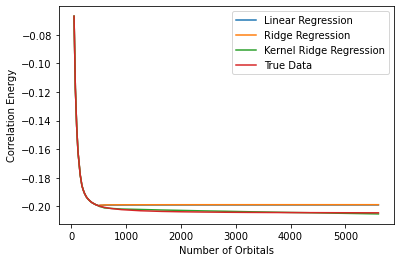

In [12]:
# Import the data set
name, dim, X_tot, y_tot, N = rs_1_N_26 ()

# Create a training data set by applying sequential formatting to the first dim points
# of the y data
X_train, y_train = format_data(y_tot[:dim])

# Optimized parameters found through hyperparameter tuning
# These parameters are (in order): Normalize, Set Intercept
params_lr = [True, True]
# These parameters are (in order): Normalize, alpha, solver
params_rr = [False, 1.175277E-15,'sag']
# These parameters are (in order): kernel, degree (N/A), alpha, coef0 (N/A), gamma
# Note that degree and coef0 are not taken into account when using the sigmoid kernel
params_krr = ['sigmoid', 1.00, 7.847600E-13, 5.00, 1.389495E+01]

# Train all three regression algorithms and use each to extrapolate to a complete data set
y_lr, mse_lr = linear_regression (X_train, y_train, y_tot, dim, params_lr, verbose=True, seq=2)
y_rr, mse_rr = ridge_regression (X_train, y_train, y_tot, dim, params_rr, verbose=True, seq=2)
y_krr, mse_krr = kernel_ridge_regression (X_train, y_train, y_tot, dim, params_krr, verbose=True, seq=2)

# Plot the three extrapolated data sets against the true data
plt.plot(X_tot, y_lr, label='Linear Regression')
plt.plot(X_tot, y_rr, label='Ridge Regression')
plt.plot(X_tot, y_krr, label='Kernel Ridge Regression')
plt.plot(X_tot, y_tot, label='True Data')

# Add axes labels and a legend
plt.xlabel('Number of Orbitals')
plt.ylabel('Correlation Energy')
plt.legend(loc='best')